In [1]:
import torch 
import random
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field

import sys
sys.path.append("..")

from model import Forecaster, plot_forecast
from configs import PatchFMConfig
from dataset import UTSDataset

/home/svilhes/anaconda3/envs/anots/lib/python3.11/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [2]:
@dataclass
class NotebookConfig:
  context_size: int = 1024 # the length of the context signal
  forecast_horizon: int = 64 # the length of the forecast horizon
  quantiles: list[float] = field(default_factory=lambda: [0.1, 0.5, 0.9]) # the quantiles to be predicted (0.5 is the forecast)

  context_plot_limit: int = 300 # not show the whole context but last 'context_plot_limit' observations (just for visualization)

config_nb = NotebookConfig()

In [3]:
# --- Instantiate model ---
config = PatchFMConfig(compile=True, load_from_hub=False, ckpt_path="../ckpts/patchfm_asinh_causal_quantiles.pth")
model = Forecaster(config)

Loading weights from local ckpt: ../ckpts/patchfm_asinh_causal_quantiles.pth


# Forecasting

In [4]:
# --- Load UTSD dataset ---
dataset = UTSDataset(input_len=config_nb.context_size, output_len=config_nb.forecast_horizon, flag="val", subset_name="UTSD-1G")

Resolving data files:   0%|          | 0/320 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/80 [00:00<?, ?it/s]

Indexing dataset...


100%|██████████| 68679/68679 [00:25<00:00, 2681.28it/s]


Context shape: (1024,), Target shape: (64,)


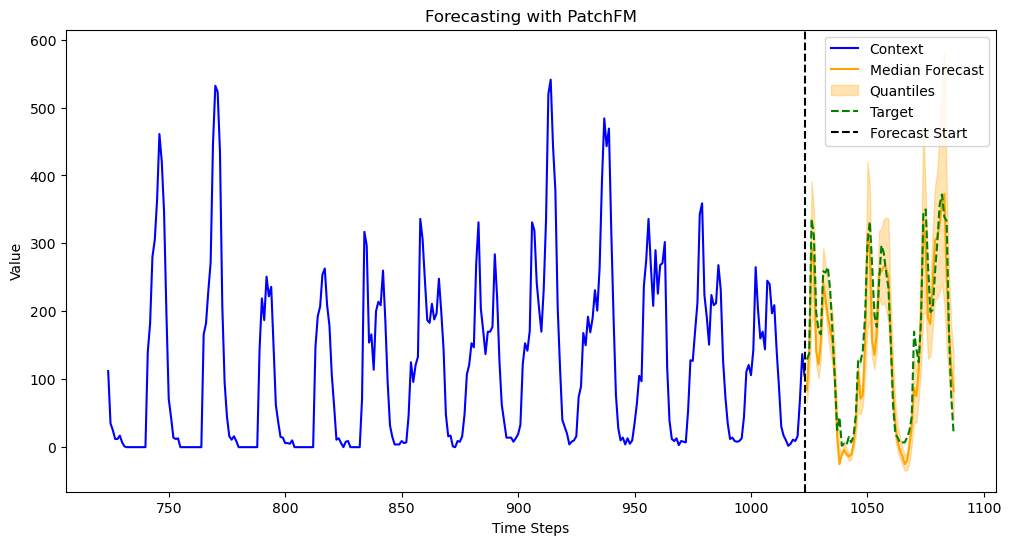

In [88]:
idx = random.randint(0, len(dataset))
context, target = dataset[idx]
xx = torch.cat([context, target], dim=0)

context = xx[:config_nb.context_size].numpy()
target = xx[config_nb.context_size:config_nb.forecast_horizon + config_nb.context_size].numpy()

print(f"Context shape: {context.shape}, Target shape: {target.shape}")

pred_median, pred_quantiles = model(context, forecast_horizon=config_nb.forecast_horizon, quantiles=config_nb.quantiles)

plot_forecast(context, pred_median, pred_quantiles, target_pred=target, context_plot_limit=config_nb.context_plot_limit)

# How to create my own input signal

Input shape: torch.Size([1, 1024]), Output shape: torch.Size([1, 64]), Quantiles: torch.Size([1, 64, 3])


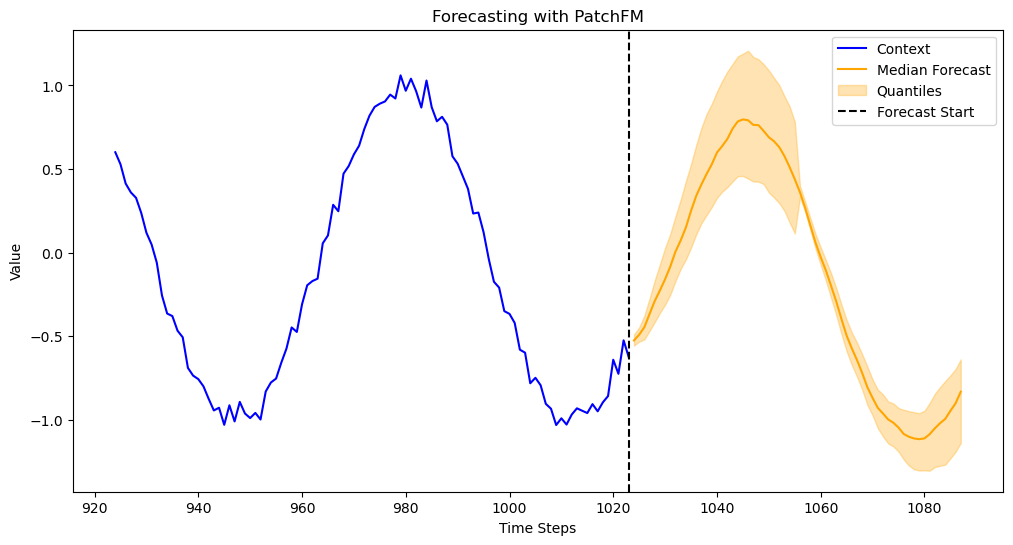

In [4]:
# --- Artificial signal creation ---
x = torch.linspace(1, 100, 1024).unsqueeze(0)
signal = torch.sin(x) + 0.05*torch.randn(1024) # (batch, time)

# --- Inference ---
forecast_horizon = 64
pred_median, pred_quantiles = model(signal, forecast_horizon=forecast_horizon, quantiles=[0.1, 0.5, 0.9])  # (batch, time, quantiles)
print(f"Input shape: {signal.shape}, Output shape: {pred_median.shape}, Quantiles: {pred_quantiles.shape}")
plot_forecast(signal, pred_median, pred_quantiles)